In [ ]:
import sys

from tests.smoke_tests.olesik_et_al_2022.test_simulation import settings

if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [1]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"

from asian_option import AsianArithmetic, Settings, plot_solution, plot_difference_arithmetic

import numpy as np
from matplotlib import pyplot
from ipywidgets import IntProgress
from tqdm import tqdm

from open_atmos_jupyter_utils import show_plot, show_anim
from monte_carlo import BSModel, FixedStrikeGeometricAsianOption, FixedStrikeArithmeticAsianOption

In [5]:
params_list=[
    {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 5.279,
    },
    {
        'T': 1,
        'K': 100,
        'r': 0.2,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 1.869,
    },
    {
        'T': 1,
        'K': 100,
        'r': 0.3,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.151,
    },
]

In [2]:
def run_numeric_and_mc(params, nx=31, ny=41, nt=300):
    settings = Settings(T=params['T'], K=params['K'], r=params['r'], sgma=params['sgma'], S_max=params['spot']*2, S_min=params['spot']/2)
    simulation = AsianArithmetic(settings, nx=nx, ny=ny, nt=nt)
    arithmetic_by_mc = np.zeros_like(simulation.S)
    arithmetic_option = FixedStrikeArithmeticAsianOption(settings.params.T, settings.params.K, 'call')
    for idx, spot in tqdm(enumerate(simulation.S)):
        model = BSModel(spot, settings.params.r, settings.params.sgma, settings.params.T, 1000)
        arithmetic_by_mc[idx] = arithmetic_option.price_by_mc(model, 100000)
    
    history = []
    progbar = IntProgress(max = simulation.nt)
    display(progbar)
    for progbar.value in range(simulation.nt + 1):
        if progbar.value != 0:
            res = simulation.step()
        history.append(simulation.solver.advectee.get().copy())
        
    _, ax = pyplot.subplots(1, 1, figsize=(10, 5))
    plot_solution(settings=settings,
                  frame_index=-1,
                  ax=ax,
                  history=history,
                  arithmetic_by_mc=arithmetic_by_mc,
                  S_linspace=simulation.S,
                  option_type='arithmetic call')
    show_plot('numeric_vs_analytic.pdf')
    _, ax = pyplot.subplots(1, 1, figsize=(10, 5))
    plot_difference_arithmetic(settings=settings,
                  frame_index=-1,
                  ax=ax,
                  history=history,
                  arithmetic_by_mc=arithmetic_by_mc,
                  S_linspace=simulation.S,
                  option_type='arithmetic call')
    show_plot('numeric_vs_analytic_error.pdf')
    
    print(f"True price: {params['true_price']}")
    print(f"Numeric price: {np.interp(params['spot'], simulation.S, history[-1][:,0])}")
    print(f"MC price: {np.interp(params['spot'], simulation.S, arithmetic_by_mc)}")

In [11]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 5.279,
    }
run_numeric_and_mc(params, nx=61, ny=130, nt=300)

self.l2=np.float64(15.494319180377357)
dx: 0.022726137067539186, dy: 1.550387596899225, dt: 0.0033333333333333335, l2: 15.494319180377357
CFL 0.4439340296032524
courant_x=np.float64(0.013934029603252575), courant_y=np.float64(0.4299999999999998)
x_dim_advector.shape=(62, 130), self.a_dim_advector.shape=(61, 131)


1it [00:03,  3.15s/it]


KeyboardInterrupt: 

self.l2=np.float64(4.765453421128755)
dx: 0.01952527269182944, dy: 1.183431952662722, dt: 0.002, l2: 4.765453421128755
CFL 0.34619450783224914
courant_x=np.float64(0.008194507832249315), courant_y=np.float64(0.33799999999999986)
x_dim_advector.shape=(72, 170), self.a_dim_advector.shape=(71, 171)


71it [02:16,  1.92s/it]


IntProgress(value=0, max=500)

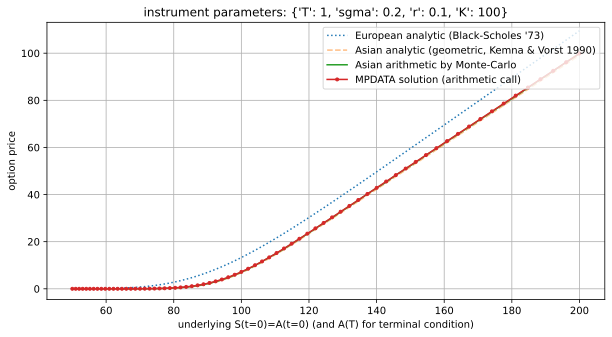

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:348: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:357: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


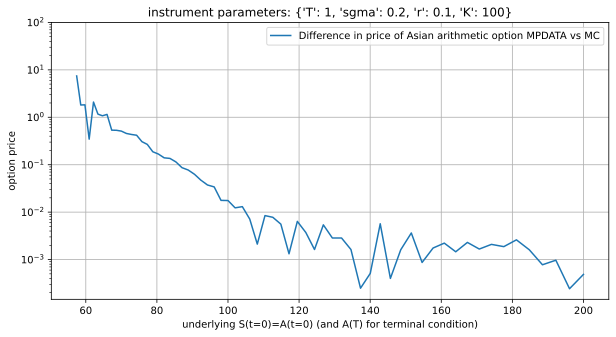

True price: 7.079
Numeric price: 7.170815710067287
MC price: 7.047072198057903


In [9]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 7.079,
    }
run_numeric_and_mc(params, nx=71, ny=170, nt=500)

In [23]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 11.213,
    }
run_numeric_and_mc(params, nx=61, ny=450, nt=1000)

self.l2=np.float64(3.227983162578616)
dx: 0.022726137067539186, dy: 0.44543429844098, dt: 0.001, l2: 3.227983162578616
CFL 0.4498800439749421
courant_x=np.float64(0.0008800439749422675), courant_y=np.float64(0.4489999999999998)
x_dim_advector.shape=(62, 450), self.a_dim_advector.shape=(61, 451)


61it [01:57,  1.92s/it]


IntProgress(value=0, max=1000)

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:79: RuntimeWarning: overflow encountered in scalar multiply
  ats(*focus_psi, -1) + (ats(*focus_psi, -1) - ats(*focus_psi, -2)) * cnst, 0
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:79: RuntimeWarning: overflow encountered in scalar multiply
  ats(*focus_psi, -1) + (ats(*focus_psi, -1) - ats(*focus_psi, -2)) * cnst, 0
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:79: RuntimeWarning: overflow encountered in scalar multiply
  ats(*focus_psi, -1) + (ats(*focus_psi, -1) - ats(*focus_psi, -2)) * cnst, 0
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:79: RuntimeWarning: overflow encountered in scalar multiply
  ats(*focus_psi, -1) + (ats(*focus_psi, -1) - ats(*focus_psi, -2)) * cnst, 0
/home/pawel/PycharmProjects/PyMP

KeyboardInterrupt: 